# 2. Data preparation

---

### Setup

In [1]:
import sys
sys.path.insert(1, '../utils')

import pandas as pd

original: pd.DataFrame = pd.read_csv('qsar_oral_toxicity_after_profiling.csv', sep=';')

## 2.0. Data preparation

---

### Missing Values Imputation

---

In our dataset there are no missing values and therefore this step is not appliable.

### Outliers Imputation
---

In [2]:
#TODO

### Scaling

---

Since all variables are binary (0 or 1) they are already scaled. Therefore, no scaling is needed.

### Data balancing

---

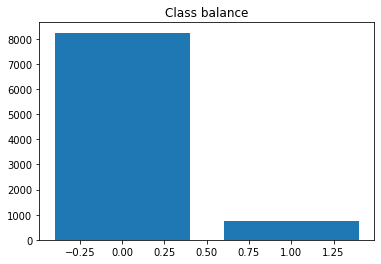

Minority class: 741
Majority class: 8250
Proportion: 0.09 : 1


In [3]:
import matplotlib.pyplot as plt

unbal = original[:]
target_count = unbal['exp'].value_counts()
plt.figure()
plt.title('Class balance')
plt.bar(target_count.index, target_count.values)
plt.show()

min_class = target_count.idxmin()
ind_min_class = target_count.index.get_loc(min_class)

print('Minority class:', target_count[ind_min_class])
print('Majority class:', target_count[1-ind_min_class])
print('Proportion:', round(target_count[ind_min_class] / target_count[1-ind_min_class], 3), ': 1')

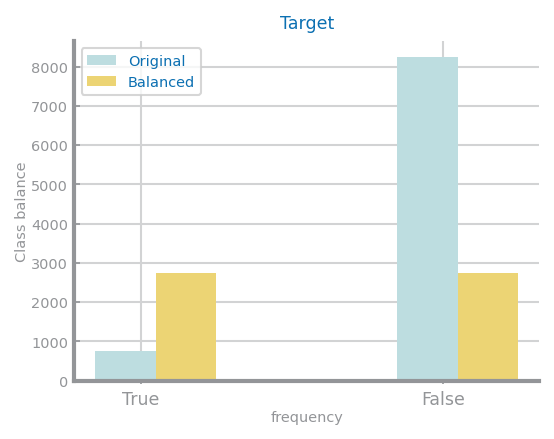

In [4]:
import ds_functions as ds

df_class_min = unbal[unbal['exp'] == min_class]
df_class_max = unbal[unbal['exp'] != min_class]

values = {'Original': [target_count.values[ind_min_class], target_count.values[1-ind_min_class]]}

FINAL_SIZE = len(df_class_max) // 3

# Oversampling
df_class_min_sample = df_class_min.sample(FINAL_SIZE, replace=True)
# Undersampling
df_class_max_sample = df_class_max.sample(FINAL_SIZE)

values['Balanced'] = [len(df_class_min_sample), len(df_class_max_sample)]

fig = plt.figure()
ds.multiple_bar_chart([target_count.index[ind_min_class], target_count.index[1-ind_min_class]], values,
                      title='Target', xlabel='frequency', ylabel='Class balance', showXTickLabels=True)
plt.show()

balanced = pd.concat((df_class_min_sample, df_class_max_sample))

In [5]:
original.to_csv('qsar_oral_toxicity_after_preparation.csv', sep=';', index=False)
balanced.to_csv('qsar_oral_toxicity_after_preparation_balanced.csv', sep=';', index=False)

### Feature Selection

---

#### Unsupervised Selection

By definition, unsupervised selection only aims for eliminating redundancies among the
variables, getting the smallest set possible.

In [6]:
import seaborn as sns
import numpy as np

copy = balanced.copy(deep=True)
copy = copy.drop('exp', axis = 1)
corrs = copy.corr()

removed = []

for x in corrs:
    for y in corrs:
        if x == y:
            break
        corr = corrs[x][y]
        if abs(corr) >= 0.9 and x not in removed and y not in removed:
            copy = copy.drop(x, axis=1)
            removed.append(x)
            break

copy['exp'] = balanced['exp']

#### Supervised Selection

In the context of supervised selection, the goal is to identify the most relevant variables
in relation to the target variable, and so we need criteria able to relate each variable
with the target one.

In [7]:
importances = copy.drop('exp', axis=1).apply(lambda x: x.corr(copy.exp))
print(importances)

bmf1      -0.081274
bmf2       0.029562
bmf3       0.108283
bmf4       0.111371
bmf5      -0.012969
             ...   
bmf1020    0.043809
bmf1021   -0.006248
bmf1022   -0.019568
bmf1023    0.004824
bmf1024   -0.022930
Length: 995, dtype: float64


In [8]:
new_copy = copy.copy(deep=True)

for i in range(0, len(importances)):
    if np.abs(importances[i]) < 0.10:
        new_copy = new_copy.drop(importances.index[i], axis=1)

In [9]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
import pandas as pd

newest_copy = new_copy.copy(deep=True)

X = pd.get_dummies(newest_copy.drop('exp', axis=1))
y = pd.get_dummies(newest_copy['exp'])


#feature selection using chi2
bestfeatures = SelectKBest(score_func=chi2, k='all')
fit = bestfeatures.fit(X, y)
#create df for scores
dfscores = pd.DataFrame(fit.scores_)
#create df for column names
dfcolumns = pd.DataFrame(X.columns)

#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
#naming the dataframe columns
featureScores.columns = ['Selected_columns','Score_chi2']

for i in range(0, len(featureScores)):
    if featureScores['Score_chi2'][i] <= 50:
        newest_copy = newest_copy.drop(featureScores['Selected_columns'][i], axis=1)

In [10]:
newest_copy.to_csv('qsar_oral_toxicity_after_preparation_selected.csv', sep=';', index=False)

### Summary

---

***Are all variables in the same scale? If not, how does scaling impact the results?***

Yes, they are all binary and, therefore, all in the same scale.

***Is the dataset unbalanced? If yes, what is the best balancing technique to apply?***

Yes, the dataset is way unbalanced. To balance it we used two techniques: oversampling for the minority class (positive) and undersampling for the majority class (negative).